<a href="https://colab.research.google.com/github/arunravi8595/CE888_Assignment_2/blob/main/UK_police_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [215]:
#Import required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier


In [216]:

#To find ethnicity distribution in Stop & Search by Police
#Data downloaded from https://data.police.uk/data/
Police_search = pd.read_csv('https://raw.githubusercontent.com/arunravi8595/CE888/main/Assignment/2020-12-essex-stop-and-search.csv') 


In [217]:
Police_search.shape

(422, 15)

In [218]:
#Check NaN in data
Police_search.isnull().sum()

Type                                          0
Date                                          0
Part of a policing operation                  0
Policing operation                          422
Latitude                                      4
Longitude                                     4
Gender                                       37
Age range                                    45
Self-defined ethnicity                       37
Officer-defined ethnicity                    48
Legislation                                   0
Object of search                              0
Outcome                                       3
Outcome linked to object of search            0
Removal of more than just outer clothing     37
dtype: int64

In [219]:
# Drop columns with NaN values
Police_search = Police_search[Police_search["Outcome"].notna()]

In [220]:
Police_search.head()

,Type,Date,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing
0,Person and Vehicle search,2020-12-01T00:01:00+00:00,False,NaN,51.881413,0.215455,Female,25-34,Other ethnic group - Not stated,White,Police and Criminal Evidence Act 1984 (section 1),Articles for use in criminal damage,A no further action disposal,False,False
1,Person search,2020-12-01T00:01:00+00:00,False,NaN,51.636110,0.062590,Female,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False
2,Person search,2020-12-01T00:01:00+00:00,False,NaN,51.636546,0.063333,Male,18-24,Black/African/Caribbean/Black British - Caribbean,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False
3,Person search,2020-12-01T01:01:00+00:00,False,NaN,51.629479,0.439730,Male,18-24,Other ethnic group - Not stated,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False
4,Vehicle search,2020-12-01T01:01:00+00:00,False,NaN,51.629479,0.439730,NaN,NaN,NaN,NaN,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,NaN


In [221]:
#Taking only the required columns from the dataset

Police_search = Police_search[['Type','Gender','Age range','Officer-defined ethnicity','Outcome','Outcome linked to object of search']]
data = Police_search.dropna()
data = data.reset_index(drop=True)
data.describe()

,Type,Gender,Age range,Officer-defined ethnicity,Outcome,Outcome linked to object of search
count,364,364,364,364,364,364
unique,2,2,4,4,5,2
top,Person search,Male,18-24,White,A no further action disposal,False
freq,287,325,159,294,284,288


**Understanding the field of importance in the data**

To know which part of the data to be checked for bias. Visualising the information from the stop and search can provide a general idea on what part needs to be analyzed.
The main task is to find how ethnicity plays a role in police search. So the information that is related to ethnic distribution is considered.

In [222]:
Police_search["Officer-defined ethnicity"].value_counts()

White    302
Black     46
Asian     12
Other     12
Name: Officer-defined ethnicity, dtype: int64

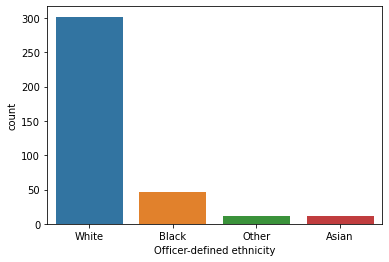

In [223]:
#Plot ethnicity distribution
sns.countplot(x="Officer-defined ethnicity", data = Police_search)

In [224]:
#Combine different Non-white categoriess into a single class

Ethnicity = []
for x in Police_search["Officer-defined ethnicity"]:
  if x == "White":
    y = "White"  
  elif x == "Other":
    y = "Other"
  else:
    y = "Non-White"     
  Ethnicity.append(y)       
  
Police_search["Ethnicity"] = Ethnicity        

In [225]:
Police_search["Ethnicity"].value_counts()

White        302
Non-White    105
Other         12
Name: Ethnicity, dtype: int64

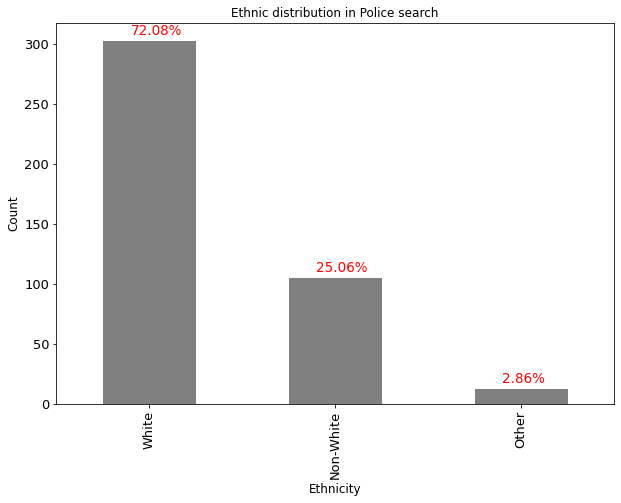

In [226]:
graph = Police_search['Ethnicity'].value_counts().plot(kind='bar', figsize=(10,7),
                                                  color="grey", fontsize=13);
graph.set_alpha(0.8)
graph.set_title("Ethnic distribution in Police search", fontsize=12)
graph.set_ylabel('Count', fontsize=12)
graph.set_xlabel('Ethnicity', fontsize=12)

totals = []

# find the values and append to list
for i in graph.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in graph.patches:
    # get_x pulls left or right; get_height pushes up or down
    graph.text(i.get_x()+0.15, i.get_height()+5, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=13.5,
                color='red')

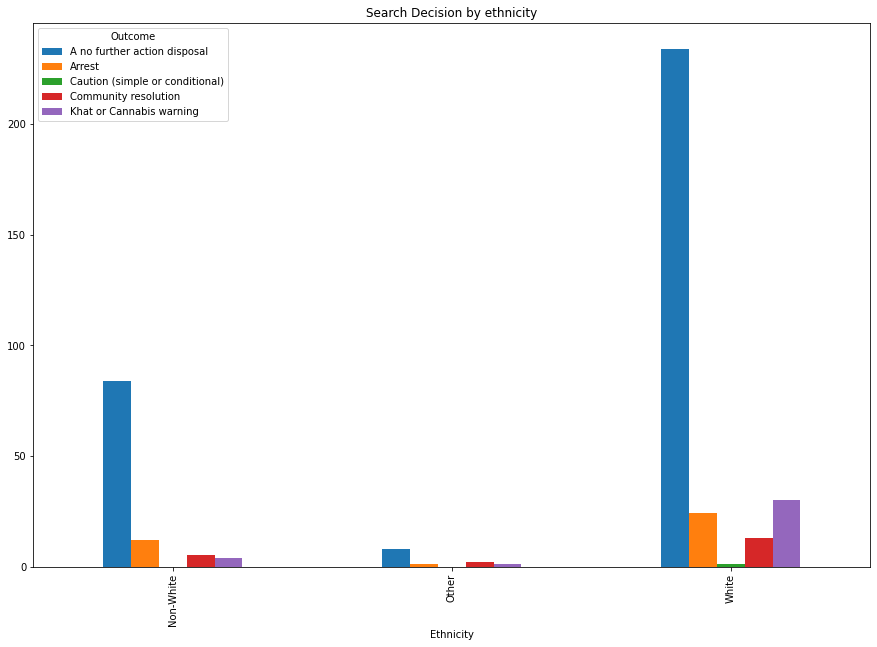

In [227]:
#To find the outcome decision taken by police officers based on ethnicity
Police_search.groupby('Outcome')['Ethnicity'].value_counts().unstack(0).plot.bar(title='Search Decision by ethnicity', figsize=(15,10));

In [228]:
# In the data, "Outcome linked to object of search" specifies whether the suspect has been arrested or not
# Hence the column is renamed as "Arrested" which has the info as TRUE or FALSE
Police_search.rename(columns = {'Outcome linked to object of search':'Arrested'}, inplace = True)
Police_search["Arrested"].value_counts()

False    332
True      87
Name: Arrested, dtype: int64

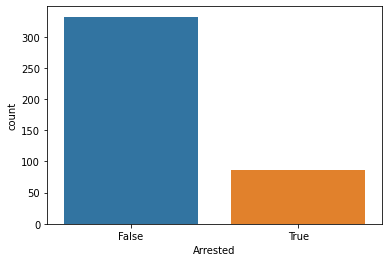

In [229]:
sns.countplot(x = "Arrested", data = Police_search)

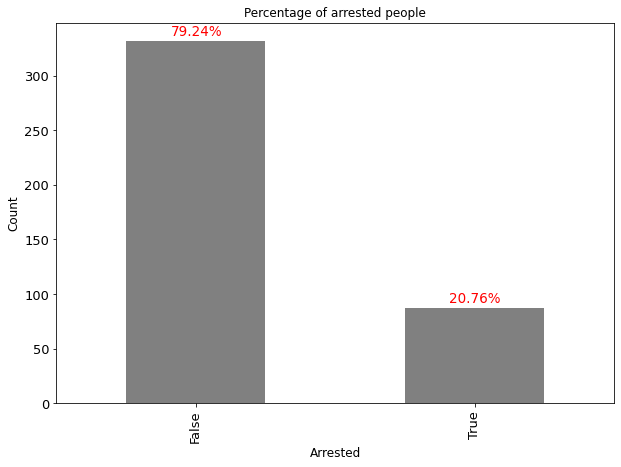

In [230]:
graph = Police_search['Arrested'].value_counts().plot(kind='bar', figsize=(10,7),
                                                  color="grey", fontsize=13);
graph.set_alpha(0.8)
graph.set_title("Percentage of arrested people", fontsize=12)
graph.set_ylabel('Count', fontsize=12)
graph.set_xlabel('Arrested', fontsize=12)

totals = []

# find the values and append to list
for i in graph.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in graph.patches:
    # get_x pulls left or right; get_height pushes up or down
    graph.text(i.get_x()+0.16, i.get_height()+5, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=13.5,
                color='red')

In [231]:
Police_search['Arrested'].value_counts(normalize=True).mul(100).astype(str)+'%'

False     79.23627684964201%
True     20.763723150357997%
Name: Arrested, dtype: object

In [232]:
arrested_df = Police_search[Police_search["Arrested"] == "True"]
sns.countplot(x = "Ethnicity", data = arrested_df)

ValueError: ignored

In [ ]:
Police_search["Gender"].value_counts()

In [ ]:
Ethnic_Arrest = Police_search[Police_search["Arrested"] == "TRUE"]
sns.countplot(x = "Ethnicity", data = Ethnic_Arrest)

**Detection of Bias and Mitigation**

Using AIF360 ML Algorithm to address the fairness metrics

In [ ]:
#importing required library packages:

import sys
sys.path.insert(1, "../")  

import numpy as np
np.random.seed(0)

!pip install aif360
!pip install 'tensorflow>=1.13.1,< 2'

import tensorflow as tf

from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing.reweighing import Reweighing


from IPython.display import Markdown, display

In [234]:
privileged_groups = [{'Ethnicity': 'White'}]
unprivileged_groups = [{'Ethnicity': 'Non-white'}]
favorable_label = 1 
unfavorable_label = 0

In [233]:
from sklearn import preprocessing

categorical_column = ['Ethnicity', 'Outcome', 'Arrested',]
data_encoded = Police_search.copy(deep=True)
#Use Scikit-learn label encoding to encode character data
lab_enc = preprocessing.LabelEncoder()
for col in categorical_column:
        data_encoded[col] = lab_enc.fit_transform(Police_search[col])
        le_name_mapping = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))
        print('Feature', col)
        print('mapping', le_name_mapping)
        

data_encoded.head()

Feature Ethnicity
mapping {'Non-White': 0, 'Other': 1, 'White': 2}
Feature Outcome
mapping {'A no further action disposal': 0, 'Arrest': 1, 'Caution (simple or conditional)': 2, 'Community resolution': 3, 'Khat or Cannabis warning': 4}
Feature Arrested
mapping {False: 0, True: 1}


,Type,Gender,Age range,Officer-defined ethnicity,Outcome,Arrested,Ethnicity
0,Person and Vehicle search,Female,25-34,White,0,0,2
1,Person search,Female,18-24,White,0,0,2
2,Person search,Male,18-24,Black,0,0,0
3,Person search,Male,18-24,White,0,0,2
4,Vehicle search,NaN,NaN,NaN,0,0,0


In [235]:
from Pipeline_LabelEncoder.sklearn_label_encoder import PipelineLabelEncoder

preprocessed_data = PipelineLabelEncoder(columns = ['Ethnicity','Outcome', 'Person Arrested']).fit_transform(data_encoded)

ModuleNotFoundError: ignored

In [ ]:
dataset_orig = Police_search(
    protected_attribute_names=['Ethnicity'],      
    )

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

privileged_groups = [{'Ethnicity': 'White'}]
unprivileged_groups = [{'Ethnicity': 'Non-White'}]

In [ ]:
Census_data.shape

In [ ]:
#Check NaN in data
Census_data.isnull().sum()

In [ ]:
Census_data.head()

In [ ]:
#Transpose column into row
Census_data = Census_data.T
Census_data.head()

In [ ]:
#Combine similar ethnic groups together
#Make ethnic classifications to match Data1 - Police search

In [ ]:
#Load Data-3
#To find ethnic distribution across the Police workforce
#Data downloaded from https://www.ethnicity-facts-figures.service.gov.uk/workforce-and-business/workforce-diversity/police-workforce/latest#by-ethnicity-police-officers
Workforce_data=pd.read_csv('https://raw.githubusercontent.com/arunravi8595/CE888/main/Assignment/by-ethnicity-police-officers-table.csv')

In [ ]:
Workforce_data.head()

In [ ]:
sns.displot(Workforce_data, bins=30, kde=True, rug=True)

In [ ]:
sns.jointplot(x='% of police officers', y='% of population', data=Workforce_data)

In [ ]:
#Compare Dataset 2 and 3 (Ethnicity in workforce and Census)
#Result of this Data will be either a match or difference between them
#If there is no percentage difference then the employment is distributed to all ethnicity equally
#If there is a difference between them, then compare the result with Data 1 (Police search) to find if the predominant ethnicity has any influence